# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image, ImageOps
from PIL import ImageFilter
from matplotlib import pyplot as plt
import cv2
from pathlib import Path
import shutil
from PIL import Image
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.collections import Counter
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import ssl
import string

try:
    from PIL import UnidentifiedImageError
except ImportError:
    UnidentifiedImageError = IOError

<a id="section1"></a>
# Section #

[Aller a la section 1](#section1)

In [ ]:
pd.set_option('display.max_rows', 500)

Import of datasets.

In [ ]:
img_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos")
img_folder_sample = img_folder / "sample"
img_folder_sample.mkdir(exist_ok=True)
dest_path = img_folder_sample / "processed_images"
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
photo = pd.read_json("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos.json", lines=True)

In [ ]:
business = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines=True)
checkin = pd.read_json("./yelp_dataset/yelp_academic_dataset_checkin.json", lines=True)
review = pd.read_json("./yelp_dataset/yelp_academic_dataset_review.json", lines=True)
tip = pd.read_json("./yelp_dataset/yelp_academic_dataset_tip.json", lines=True)
user = pd.read_json("./yelp_dataset/yelp_academic_dataset_user.json", lines=True)

In [ ]:
LABELS = list(photo['label'].unique())

In [ ]:
def select_and_copy_images(dataframe, source_path:Path, dest_path:Path, num_images:int):
    sample = pd.DataFrame(columns=dataframe.columns)

    for label in dataframe['label'].unique():
        sample = pd.concat([sample, dataframe.loc[dataframe['label']==label,:].sample(n=num_images)])
    
    print(f"Taille de l'échantillon : {len(sample)}")

    # Copying selected images to sample folder
    for img in source_path.glob('*.jpg'):
        if img.stem in sample['photo_id'].to_list():
            shutil.copyfile(img, dest_path / img.name)
            sample.loc[sample['photo_id'] == img.stem, 'path'] = str(img)
    
    return sample

def jpg_to_png(img_path:Path) -> Path:
    # Create png dir if not exist
    png_folder = img_path.parent / "png_img"
    png_folder.mkdir(exist_ok=True)
    
    # Log error file if not exist
    log_error_file = png_folder / "log_errors.txt" 
    log_error_file.touch(exist_ok=True)

    if img_path.suffix == '.jpg':
        try:
            with Image.open(img_path) as img:
                png_img = img_path.stem + ".png"
                img.save(png_folder / png_img, "PNG")
                png_img = Path(png_folder.absolute() / png_img)
                return png_img
        except IOError as e:
            with open(log_error_file, 'a') as file:
                file.write(f"Impossible de traiter l'image {img_path.name}: {e}")

    else:
        return img_path
    
def process_images(directory:Path, batch_size=100):
    # Get the list of images
    images = list(directory.glob('*.jpg'))

    # Create destination dir if not exist
    dest_folder = directory / "processed_images"
    dest_folder.mkdir(exist_ok=True)

    # Create file for record errors if not exist
    error_file = dest_folder / "errors.txt"   
    error_file.touch(exist_ok=True)

    for i in range(0, len(images), batch_size):
        for img_path in images[i: i + batch_size]:

            # Conversion to png if necessary
            img_path = jpg_to_png(img_path)

            try:
                img = Image.open(img_path)
                img.verify()
            except (UnidentifiedImageError, IOError):
                with open(error_file, 'a') as file:
                    file.write(f"Le fichier {img_path} n'a pas pu être identifié comme une image valide.")
                continue
            
            img = Image.open(img_path)

            # Median filter --> Gaussien filter instead
            img = img.filter(ImageFilter.MedianFilter(size=3))

            # Equalize histogram
            img = ImageOps.equalize(img)

            # Path destination
            dest_path = dest_folder / img_path.name

            # Save image processed
            img.save(dest_path)

            # Free memory
            img.close()

def sift_features(directory:Path, batch_size=100):
    destination_path = directory / 'sift'
    destination_path.mkdir(exist_ok=True)
    
    # Create SIFT detector
    sift = cv2.SIFT_create()

    batch_num = 0
    batch_descriptors = list()
    images_files = list(directory.glob('*.png'))
    total_images = len(images_files)
    images_processed = 0
    image_names = list()

    # Pour le diagnostic
    descriptor_count = {}

    # Iterate over all images
    for i, img_path in enumerate(images_files):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = sift.detectAndCompute(img, None)

        if descriptors is not None:
            batch_descriptors.extend(descriptors)
            for _ in range(len(descriptors)):
                image_names.append(img_path.stem)

            # Ajout dans le dictionnaire pour le diagnostic
            descriptor_count[img_path.stem] = len(descriptors)

            images_processed += 1
        
        if images_processed >= batch_size or i == total_images - 1:
            # Concatenate all numpy array in batch_descriptors in one numpy array
            descriptors_to_save = np.vstack(batch_descriptors)
            descriptor_path = destination_path / f"descriptors_batch_{batch_num}.npy"
            image_names_path = destination_path / f"images_names_batch_{batch_num}.npy"
            np.save(image_names_path, np.array(image_names))
            np.save(descriptor_path, descriptors_to_save)
            batch_descriptors = list()
            images_processed = 0
            batch_num += 1
            image_names = list()

    # # Afficher les statistiques de descripteurs
    # print("Nombre de descripteurs par image :")
    # for photo_id, count in descriptor_count.items():
    #     print(f"{photo_id}: {count}")

    return batch_num

def load_descriptors(directory:Path):
    descriptor_files = list(directory.glob('descriptors_batch_*.npy'))

    all_descriptors = [np.load(file) for file in descriptor_files]

    all_descriptors_stacked = np.vstack(all_descriptors)

    return all_descriptors_stacked

def elbow_method(descriptors, range_n_clusters):
    inertia = list()

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(descriptors)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range_n_clusters, inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

def apply_pca_and_kmean(descriptors, n_components=None, n_clusters=100):
    # Descriptors normalisation before ACP
    scaler = StandardScaler()
    descriptors_scaled = scaler.fit_transform(descriptors)

    # Apply ACP
    pca = PCA(n_components=n_components, random_state=42)
    descriptors_pca = pca.fit_transform(descriptors_scaled)

    # Apply Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors_pca)

    return pca, kmeans, kmeans.cluster_centers_, descriptors_pca

def create_photo_cluster_table(directory, kmeans_labels):
    # Load images
    image_names_files = list(Path(directory).glob('images_names_batch_*.npy'))
    image_names = [np.load(file) for file in image_names_files]
    image_names = np.concatenate(image_names)

    # Create Dataframe
    photo_cluster_df = pd.DataFrame({
        'photo_id' : image_names,
        'cluster_label' : kmeans_labels
    })
    
    # Get the most frequent cluster by photo
    photo_cluster_df = photo_cluster_df.groupby('photo_id')['cluster_label'].agg(lambda x: x.value_counts().index[0])

    # Reset index to turn the Series back into a DataFrame
    photo_cluster_df = photo_cluster_df.reset_index()

    return photo_cluster_df

In [ ]:
photo_sample = select_and_copy_images(photo, img_folder, img_folder_sample, 200)

In [ ]:
process_images(img_folder_sample)

In [ ]:
batch_sift = sift_features(dest_path)

In [ ]:
img_folder_sample_sift = dest_path / "sift"

In [ ]:
# Load descriptors and train KMeans with k = 5 because we have 5 categories of photo
descriptors = load_descriptors(img_folder_sample_sift)
pca_model, kmeans_model, cluster_center, descriptors_pca = apply_pca_and_kmean(descriptors, n_components=0.80, n_clusters=5)

In [ ]:
elbow_method(descriptors, range(2,10));

In [ ]:
photo_cluster_df = create_photo_cluster_table(img_folder_sample_sift, kmeans_model.labels_)

In [ ]:
encoder = LabelEncoder()
photo['label_numeric'] = encoder.fit_transform(photo['label'])
comparison_df = photo_cluster_df.merge(photo[['photo_id','label_numeric']], left_on='photo_id', right_on='photo_id')
#cluster_mod = comparison_df.groupby('cluster_label')['label_numeric'].agg(lambda x: x.mode()[0])
#comparison_df['predicted_category'] = comparison_df['cluster_label'].map(cluster_mod)

In [ ]:
# Utilisation de la fonction crosstab pour créer la matrice de correspondance
correspondence_matrix = pd.crosstab(comparison_df['label_numeric'], comparison_df['cluster_label'])

# Affichage de la matrice de correspondance
print(correspondence_matrix)

# Visualisation de la matrice de correspondance en tant que heatmap
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(correspondence_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Correspondence Matrix Heatmap')
plt.show();

In [ ]:
#conf_matrix = confusion_matrix(comparison_df['label_numeric'], comparison_df['predicted_category'])

# labels = encoder.classes_
# sns.set(context='talk', style='whitegrid')
# plt.figure(figsize=(10,8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title('Matrice de Confusion')
# plt.xlabel('Prédictions')
# plt.ylabel('Véritables Étiquettes')
# plt.show()

In [ ]:
ari_score = adjusted_rand_score(comparison_df['label_numeric'], comparison_df['cluster_label'])
print("Adjusted Rand Index:", ari_score)

In [ ]:
pca_model, kmeans_model, cluster_center, descriptors_pca = apply_pca_and_kmean(descriptors, n_components=0.80, n_clusters=5)


In [ ]:
def visualize_clusters_with_tsne(descriptors_pca, kmeans_labels, perplexity=30, n_iter=1000):
    # Apply t-SNE on descriptors
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    descriptors_tsne = tsne.fit_transform(descriptors_pca)

    # Visualisation
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(kmeans_labels)
    for label in unique_labels:
        cluster_descriptors = descriptors_tsne[kmeans_labels == label]
        plt.scatter(cluster_descriptors[:, 0], cluster_descriptors[:, 1], label=f'Cluster {label}')

In [ ]:
# Avec 5 clusters
#visualize_clusters_with_tsne(descriptors_pca, kmeans_model.labels_)

# CNN unsupervised

In [ ]:
# Diviser le DataFrame de manière stratifiée
train_df, validation_df = train_test_split(
    photo_sample, 
    test_size=0.2,
    stratify=photo_sample['label'],
    random_state=42
)

In [ ]:
# Set paths for architecture folder
cnn_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn")
cnn_folder.mkdir(exist_ok=True)

train_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn/train")
train_folder.mkdir(exist_ok=True)

validation_folder = Path("/Users/matthieudridi/Documents/OpenClassrooms_Ingénieur IA/Improve_your_AI_product/yelp_photos/photos/cnn/validation")
validation_folder.mkdir(exist_ok=True)

# Copy images
for label in LABELS :
    train_label_path = train_folder / label
    train_label_path.mkdir(exist_ok=True)
    validation_label_path = validation_folder / label
    validation_label_path.mkdir(exist_ok=True)

    for img in img_folder.glob('*.jpg'):
        if img.stem in train_df['photo_id'].to_list() and train_df.loc[train_df['photo_id']==img.stem,'label'].values == label:
            shutil.copyfile(img, train_label_path / img.name)
        elif img.stem in validation_df['photo_id'].to_list() and validation_df.loc[validation_df['photo_id']==img.stem,'label'].values == label:
            shutil.copyfile(img, validation_label_path / img.name)

In [ ]:
#shutil.rmtree(train_folder)
#shutil.rmtree(validation_folder)

In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Créer un ImageDataGenerator pour le prétraitement
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(224, 224),
        batch_size = batch_size, 
        class_mode='categorical')
    
    i = 0
    labels_name = list(generator.class_indices.keys())
    
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch

        i += 1
        
        if i * batch_size >= sample_count:
            break

    return features, labels, labels_name

In [ ]:
train_features, train_labels, train_labels_name = extract_features(train_folder, 800)

In [ ]:
validation_features, validation_labels, validation_labels_name = extract_features(validation_folder, 200)

In [ ]:
train_features = np.reshape(train_features, (800, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (200, 7 * 7 * 512))

In [ ]:
model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
# Prédire les étiquettes pour l'ensemble de validation
val_predictions = model.predict(validation_features)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_labels.argmax(1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, val_predicted_labels)

# Afficher la matrice de confusion
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_labels_name, yticklabels=train_labels_name)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables Étiquettes')
plt.show()

# CNN

In [ ]:
photo_sample['label'].value_counts()

In [ ]:
# Diviser le DataFrame de manière stratifiée
train_df, validation_df = train_test_split(
    photo_sample, 
    test_size=0.2,
    stratify=photo_sample['label'],
    random_state=42
)

In [ ]:
# Créer un ImageDataGenerator pour le prétraitement
datagen = ImageDataGenerator(rescale=1./255)

# Créer le train_generator avec train_df
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Créer le validation_generator avec validation_df
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base pour ne pas les réentraîner
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Créer un modèle séquentiel
model = Sequential()

# Ajouter le modèle de base
model.add(base_model)

# Ajouter des nouvelles couches
model.add(Flatten())

# Ajouter une couche Dense avec régularisation L2
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Ajouter une couche Dense avec régularisation L2
model.add(Dense(64, activation='relu'))

# Augmenter le taux de dropout pour plus de régularisation
model.add(Dropout(0.5))

# La dernière couche Dense pour la classification finale, pas besoin de régularisation ici
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Obtenir les noms et indices des classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Identifier les classes uniques et leurs fréquences dans le générateur
unique_classes, class_counts = np.unique(train_generator.classes, return_counts=True)

# Calculer les poids pour les classes uniques
class_weights = compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_generator.classes)

# Créer un dictionnaire de poids de classe en fonction des noms de classe
class_weights_dict = {class_names[class_idx]: weight for class_idx, weight in zip(unique_classes, class_weights)}

# Ajuster les poids de classe en fonction des indices réels
adjusted_class_weights = {class_indices[class_name]: weight for class_name, weight in class_weights_dict.items()}

# Ajouter manuellement un poids par défaut pour toute classe manquante
for class_name, class_index in class_indices.items():
    if class_index not in adjusted_class_weights:
        adjusted_class_weights[class_index] = np.mean(list(class_weights_dict.values()))

# Vérifier les poids ajustés
print(adjusted_class_weights)


In [ ]:
# Nombre d'époques pour l'entraînement
epochs = 10

# Entraîner le modèle avec les poids des classes ajustés
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=adjusted_class_weights)

In [ ]:
# Tracer l'accuracy d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy au Cours des Époques')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend()
plt.show()

In [ ]:
# Créer un nouveau générateur de validation pour les prédictions sans mélange
validation_generator_for_pred = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=img_folder_sample,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important pour garder le même ordre
)

# Prédire les étiquettes pour l'ensemble de validation
val_predictions = model.predict(validation_generator_for_pred)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_generator_for_pred.classes

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, val_predicted_labels)

# Obtenir les noms des classes pour les étiquettes de l'axe
class_labels = list(validation_generator_for_pred.class_indices.keys())

# Afficher la matrice de confusion
sns.set(context='talk', style='whitegrid')
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables Étiquettes')
plt.show()

In [ ]:
# Prédire les étiquettes pour l'ensemble de validation avec shuffle=False
val_predictions = model.predict(validation_generator_for_pred)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_labels = validation_generator_for_pred.classes

# Calculer l'Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, val_predicted_labels)

print(f"L'Adjusted Rand Index est : {ari_score}")

In [ ]:
def predict_image(model, img_path, target_size=(224,224)):
    # Charger et prétraiter l'image
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisation

    # Prédiction
    prediction = model.predict(img_array)

    class_indices = train_generator.class_indices
    classes = list(class_indices.keys())

    # Obtenir le label de la classe avec la plus haute probabilité
    predicted_class = classes[np.argmax(prediction)]

    print(f"Classe prédite pour l'image: {predicted_class}")

    return prediction

# Détection des sujets d'insatisfaction

## Chargement des données

Faire en sorte de prendre un sample avec des 'user_id' unique.

In [2]:
import sys
from pathlib import Path

# Ajout chemin du dossier racine au sys.path
if str(Path().absolute().parents[0]) not in sys.path:
    sys.path.append(str(Path().absolute().parents[0]))
    
from src.data_processing.general_preprocessing import clean_comment, tokenize_comment, delete_stopwords, lemmatized_tokens

In [3]:
review = pd.read_json("../data/raw/yelp_dataset/yelp_academic_dataset_review.json", lines=True)
review_sample = review.loc[review['stars']==1,'text'].sample(n=10000)
review_sample = review_sample.to_frame()

## Preprocessing des données

In [4]:
review_sample['clean_comment'] = review_sample['text'].apply(clean_comment)
review_sample['tokens'] = review_sample['clean_comment'].apply(tokenize_comment)
review_sample['tokens_without_stopwords'] = review_sample['tokens'].apply(delete_stopwords)
review_sample['tokens_lemm'] = review_sample['tokens_without_stopwords'].apply(lemmatized_tokens)

## EDA

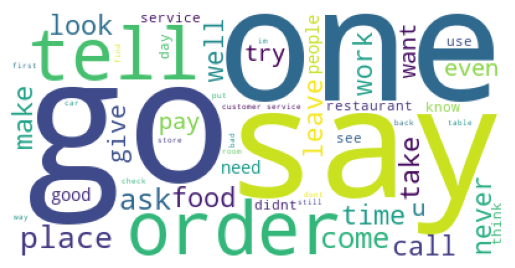

In [9]:
joined_corpus = " ".join([" ".join(word) for word in review_sample['tokens_lemm'].values])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(joined_corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

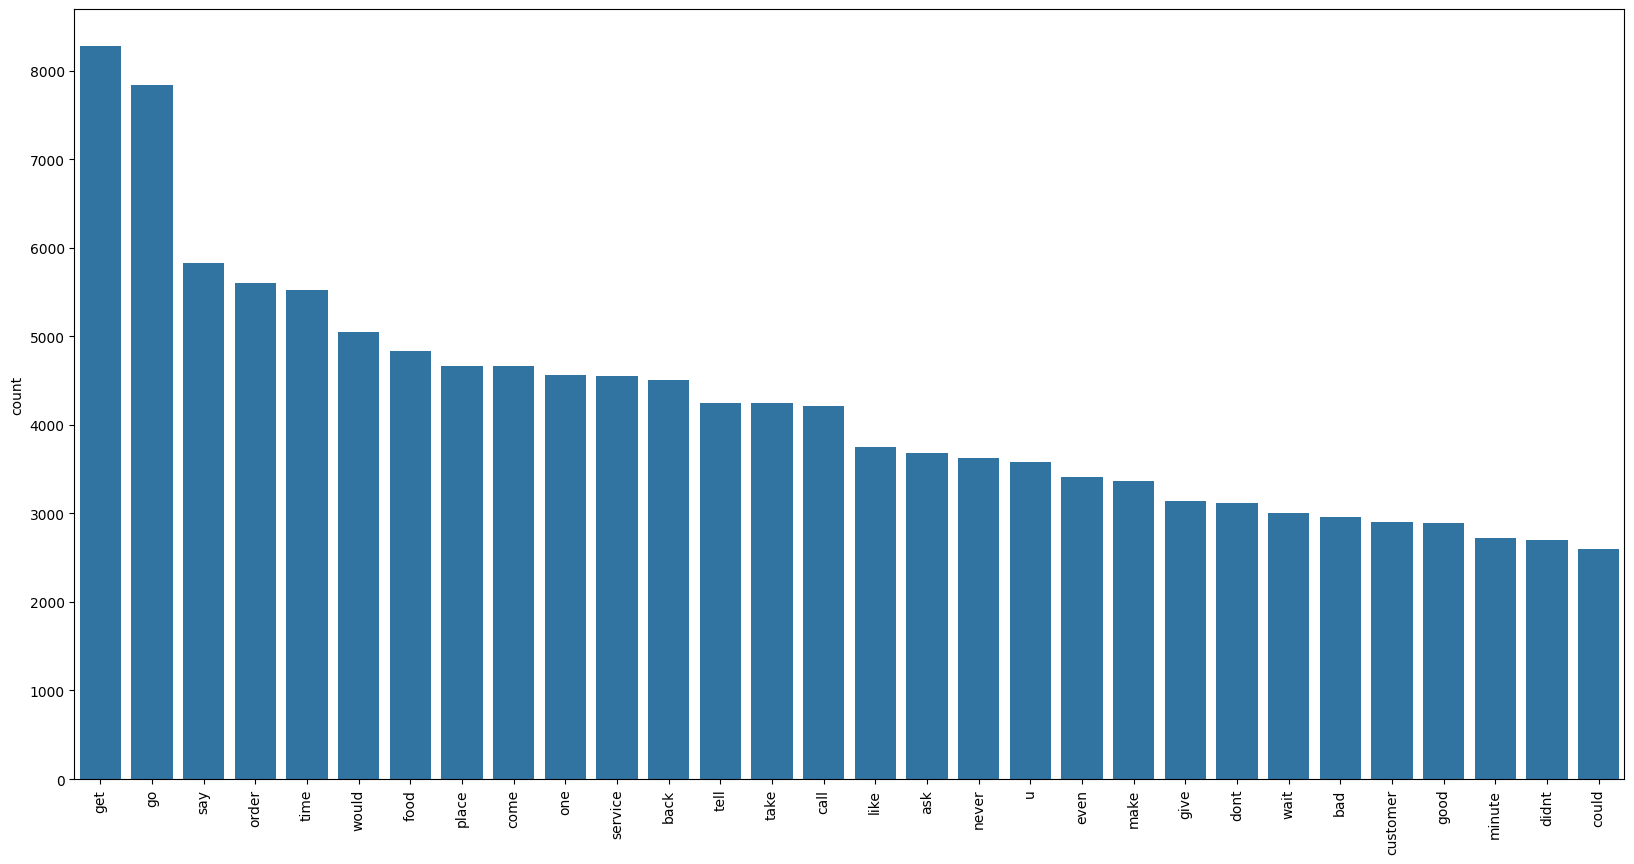

In [10]:
word_freq = pd.Series(joined_corpus.split()).value_counts()
plt.figure(figsize=(20,10))
sns.barplot(word_freq.head(30))
plt.xticks(rotation=90);

Supprimer les chiffres.
Supprimer les adverbes.

## Modeling

In [5]:
from src.data_processing.lda_preprocessing import create_bow, create_tfidf
from src.models.lda_tuning import tune_lda_coherence, tune_lda_perplexity
from src.visualization.lda_visualisation import gensim_print_top_words_topics, sklearn_print_top_words

Gensim lda tune coherence score: bow, tf-idf
Sklearn lda tune perplexity
Enlever les commentaires non anglophones

### Bag of words : gensim

In [6]:
# Create bag of words
bow, features_names_bow, bow_gensim, dictionary_gensim = create_bow(review_sample['tokens_lemm'])

In [7]:
# LDA tuning
topic_range = range(2, 7)
max_df_range = np.linspace(0.5, 0.95, 10)
alpha_range = list(np.arange(0.01, 1, 0.3))
eta_range = list(np.arange(0.01, 1, 0.3))

#best_model_gensim_bow, best_params_gensim_bow, best_score_gensim_bow = tune_lda_coherence(review_sample['tokens_lemm'], bow_gensim, dictionary_gensim, topic_range, alpha_range, eta_range)

In [11]:
# LDA best_params_gensim_bow : {'num_topics': 5, 'alpha': 0.31, 'eta': 0.9099999999999999}
best_model_gensim_bow = LdaMulticore(corpus=bow_gensim, 
                                    id2word=dictionary_gensim, 
                                    num_topics=5, 
                                    random_state=100, 
                                    chunksize=100, 
                                    passes=10, 
                                    alpha=0.31, 
                                    eta=0.91)

In [12]:
gensim_print_top_words_topics(best_model_gensim_bow, 5, 10)

Topic 1: minus ketchup responsibility coincidence marsh string maria tear state sot
Topic 2: frizy insulting light baasssic eggrollsenjoy refundable nonresponsive field basically condense
Topic 3: improperly cease confuse courthouse puddle img disdain communicate melissa oem
Topic 4: instructed frizy refundable insulting baasssic pho eggrollsenjoy gps light condense
Topic 5: pho fell frizy insulting manger gps refundable incur condense baasssic


### Bag of words : sklearn

max_features dans mon vectorizer : garder les 5000 mots les plus fréquents
Regarder s'il existe un hyperparamètre qui permet de limiter l'apparition du même mot dans plusieurs topics
log likely hood : log vraisemblance

In [34]:
bow.todense().shape

(10000, 24102)

In [13]:
# LDA tuning with perplexity
topic_range = range(2, 7)
best_model_sklearn_bow, best_params_sklearn_bow, best_score_sklearn_bow = tune_lda_perplexity(bow, topic_range, max_iter=10)

N_topics : 2, perplexity : 1125.2302715905253
N_topics : 3, perplexity : 1110.0101561153874
N_topics : 4, perplexity : 1124.4261695764017
N_topics : 5, perplexity : 1140.016752351747
N_topics : 6, perplexity : 1143.0451932653743


In [14]:
best_params_sklearn_bow

3

In [11]:
#best_params_sklearn_bow = 3
best_params_sklearn_bow = LatentDirichletAllocation(n_components=4,
                                                    max_iter=10,
                                                    learning_method='online',
                                                    random_state=100).fit(bow)

In [17]:
sklearn_print_top_words(best_model_sklearn_bow,features_names_bow.get_feature_names_out(), 10)

Topic #0: call get would say tell service go time car back
Topic #1: order food get go place come good like time restaurant
Topic #2: go get say one place time like ask room would


Supprimer les mots présents dans les 3 topics ?

### TF-IDF : gensim

In [14]:
# Create tf-idf
tfidf, features_names_tfidf, tfidf_gensim, dictionary_gensim = create_tfidf(review_sample['tokens_lemm'])

In [ ]:
# LDA tuning
topic_range = range(2, 7)
max_df_range = np.linspace(0.5, 0.95, 10)
alpha_range = list(np.arange(0.01, 1, 0.3))
eta_range = list(np.arange(0.01, 1, 0.3))

#best_model_gensim_tfidf, best_params_gensim_tfidf, best_score_gensim_tfidf = tune_lda_coherence(review_sample['tokens_lemm'], tfidf_gensim, dictionary_gensim, topic_range, alpha_range, eta_range)

In [15]:
#best_params_gensim_tfidf : {'#num_topics': 5, 'alpha': 0.31, 'eta': 0.01}
best_model_gensim_tfidf = LdaMulticore(corpus=tfidf_gensim, 
                                         id2word=dictionary_gensim, 
                                         num_topics=5, 
                                         random_state=100, 
                                         chunksize=100, 
                                         passes=10, 
                                         alpha=0.31, 
                                         eta=0.01)

In [16]:
gensim_print_top_words_topics(best_model_gensim_tfidf, 5, 10)

Topic 1: disrespected nitrogen older crawfishgumbo portionsfood 5131 reality freeon typically wiregrass
Topic 2: 1259 nordstrom lori greenville 2010 nitrogen freeon peices 5131 rib
Topic 3: peices 722 1259 5131 relleno illegitimate nitrogen forcing vegetarian misinformation
Topic 4: crack hotspur maintained claw injuriesat windshieldthey cascade drivewow fk 5131
Topic 5: hurtful ethnic tapeo hep inspecting carne reality freeon vial ashls


### TF-IDF : sklearn

In [17]:
# LDA tuning with perplexity
topic_range = range(2, 7)
best_model_gensim_tfidf, best_params_gensim_tfidf, best_score_gensim_tfidf = tune_lda_perplexity(tfidf, topic_range, max_iter=10)

In [29]:
#best_params_sklearn_bow = 2
best_params_sklearn_tfidf = LatentDirichletAllocation(n_components=4, 
                                                    max_iter=10, 
                                                    learning_method='online', 
                                                    random_state=100).fit(tfidf)

perplexity varie peu ? Graphique à faire.

In [30]:
sklearn_print_top_words(best_params_sklearn_tfidf,features_names_tfidf, 10)

Topic #0: timeso tonightfailure depends lactose chuys connor experence mrs kohns disgustingordered
Topic #1: botox bruce terribledont leban yarn craig fbi nitrogen allegro staffgarbage
Topic #2: custard rm worstever conesand overpricedstale gritty la zoo vparkingcard vanderbilt
Topic #3: get go order food time service place say come would


# Essais

In [ ]:
# Création d'une instance de SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fonction pour obtenir le score de sentiment
def get_vader_sentiment(comment):
    # Calcul des scores de sentiment
    sentiment_dict = sia.polarity_scores(comment)
    # Retourne le score 'composé' qui est une métrique globale de sentiment
    return sentiment_dict['compound']

# Application de cette fonction aux commentaires nettoyés
review_sample['vader_sentiment'] = review_sample['cleaned_comment'].apply(get_vader_sentiment)

In [ ]:
def remove_most_frequent_words(text:str, n:int):
    most_freq_words = pd.Series(corpus.split()).value_counts().head(n).index
    return ' '.join(word for word in text.split() if word not in most_freq_words)

corpus_witout_freq_word = remove_most_frequent_words(corpus, 20)
word_freq_2 = pd.Series(corpus_witout_freq_word.split()).value_counts()
word_freq_2